In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data imports

In [ ]:
# read data for Marapong
data_for_model = pd.read_csv(r'C:\Users\Shivm\Documents\Masters\Research Project\Eskom air quality data\Eskom Model\PM10 Models\Combined Station Data.csv')
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model = data_for_model[data_for_model['Location_Marapong']==True]
data_for_model['NO1'] = data_for_model['NO1'].fillna(data_for_model['NOX'] - data_for_model['NO2'])
data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
417970,2014/01/01 00:00:00,0.639000,168.40000,NaN,NaN,NaN,65.42000,0.128489,-0.625949,17.33700,NaN,21.71,NaN,2014-01-01 00:00:00,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639000,NaN,0.639000,NaN,0.639000,NaN,0.639000,NaN,168.400000,NaN,168.400000,NaN,168.400000,NaN,168.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.420000,NaN,65.420000,NaN,65.420000,NaN,65.420000,NaN,0.128489,NaN,0.128489,NaN,0.128489,NaN,0.128489,NaN,-0.625949,NaN,-0.625949,NaN,-0.625949,NaN,-0.625949,NaN,17.337000,NaN,17.337000,NaN,17.337000,NaN,17.337000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.710000,NaN,21.710000,NaN,21.710000,NaN,21.710000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,False,False,True,False,True,False
417971,2014/01/01 01:00:00,0.688000,182.60000,NaN,NaN,NaN,132.00998,-0.031210,-0.687292,2.63698,NaN,25.25,NaN,2014-01-01 01:00:00,1.0,1.0,2.0,0.639000,168.40000,NaN,NaN,NaN,65.42000,0.128489,-0.625949,17.33700,NaN,21.71,NaN,0.663500,0.034648,0.663500,0.034648,0.663500,0.034648,0.663500,0.034648,175.500000,10.040916,175.500000,10.040916,175.500000,10.040916,175.500000,10.040916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.714990,47.086226,98.714990,47.086226,98.714990,47.086226,98.714990,47.086226,0.048640,0.112924,0.048640,0.112924,0.048640,0.112924,0.048640,0.112924,-0.656620,0.043376,-0.656620,0.043376,-0.656620,0.043376,-0.656620,0.043376,9.986990,10.394484,9.986990,10.394484,9.986990,10.394484,9.986990,10.394484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.480000,2.503158,23.480000,2.503158,23.480000,2.503158,23.480000,2.503158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,False,False,True,False,True,False
417972,2014/01/01 02:00:00,1.467000,131.20000,NaN,NaN,NaN,165.30998,1.103793,-0.966297,12.04798,NaN,25.31,NaN,2014-01-01 02:00:00,2.0,1.0,2.

In [3]:
#null checks
data_for_model.isna().sum()

Date                   0
Wind                1181
Wind Dir            2209
SO2                23930
NO2                10086
                   ...  
Season_Spring          0
Season_Summer          0
Season_Winter          0
DayType_Weekday        0
DayType_Weekend        0
Length: 138, dtype: int64

In [4]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year
data_for_model.drop(columns=['Date', 'Date Time'], inplace=True)


In [5]:
data_for_model.columns

Index(['Wind', 'Wind Dir', 'SO2', 'NO2', 'NOX', 'PM10', 'wind_x', 'wind_y',
       'PM2.5', 'Pressure',
       ...
       'Location_Marapong', 'Location_Medupi', 'Location_Phola',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'DayType_Weekday', 'DayType_Weekend', 'Year'],
      dtype='object', length=137)

## Create Target variable and rolling features

In [6]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
data_for_model['PM2.5_lag2'] = data_for_model['PM2.5'].shift(2)
data_for_model['PM2.5_lag3'] = data_for_model['PM2.5'].shift(3)
data_for_model['PM2.5_t+1'] = data_for_model['PM2.5'].shift(-1)

data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)


data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
df_train = data_for_model[data_for_model['Year'] == 2016]
df_test = data_for_model[data_for_model['Year'] == 2017]
df_val = data_for_model[data_for_model['Year'] == 2018]


In [7]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+1,PM2.5_diff1,Temp_diff1
0,3.208356,358.94160,1.033,2.163,0.839,23.24,-0.059263,3.207809,10.480,915.0,27.48,1.860,13.0,7.0,3.0,2.680954,20.30426,44.313,2.617,0.555,22.74,0.930305,2.514368,7.777,916.0,27.65,1.077,2.802050,0.361312,2.720282,0.249969,1.866134,0.984098,1.560981,0.886354,129.258343,198.998648,92.434340,149.637854,118.820518,115.975092,110.714151,114.123722,15.115333,25.291196,11.336500,21.989726,7.832100,13.056850,6.591833,9.616010,3.367000,1.707371,2.525250,2.185768,9.766100,9.641124,8.618333,7.527397,0.950667,0.461741,1.116500,0.502134,20.687400,30.673808,15.425222,23.295541,23.200000,0.441362,23.673333,3.073393,18.309917,8.583409,12.770550,9.743408,0.414774,0.496088,0.873624,0.753475,0.733375,0.831991,0.540566,0.694615,2.737061,0.407877,2.473869,0.517977,1.180648,1.316022,0.999510,1.151310,7.030333,3.877301,9.701400,5.632816,7.454091,4.585167,10.249316,10.119395,912.000000,6.082763,912.000000,6.082763,912.000000,6.082763,912.000000,6.082763,27.500000,0.141067,24.996667,3.178148,18.654167,7.070334,18.405217,5.956002,1.146333,0.681650,0.859750,0.798927,13.173300,21.324687,9.387000,16.150405,False,False,False,False,True,False,False,False,False,False,True,True,False,2015,2.834,9.053,12.410,2.703,-0.17
1,3.552827,1.62133,1.214,1.608,0.181,24.47,0.100523,3.551405,12.410,915.0,27.44,0.000,13.0,7.0,3.0,3.208356,358.94160,1.033,2.163,0.839,23.24,-0.059263,3.207809,10.480,915.0,27.48,1.860,3.147379,0.439123,2.884986,0.404612,2.121544,0.991580,1.606078,0.960424,126.955730,201.122713,83.344244,154.387535,100.937321,117.642331,109.983680,114.796928,15.520000,24.935634,9.312000,19.574321,7.462300,13.200323,6.377389,9.694570,2.129333,0.505342,2.927250,1.648312,9.433300,9.880838,8.615556,7.530125,0.525000,0.330024,0.758250,0.538733,20.224700,30.973391,15.277667,23.388194,23.483333,0.890300,24.636667,1.868782,20.118750,7.182254,13.508050,10.053643,0.323855,0.531243,0.518163,0.554167,0.756468,0.80

## Correlation Matrix to identify best features

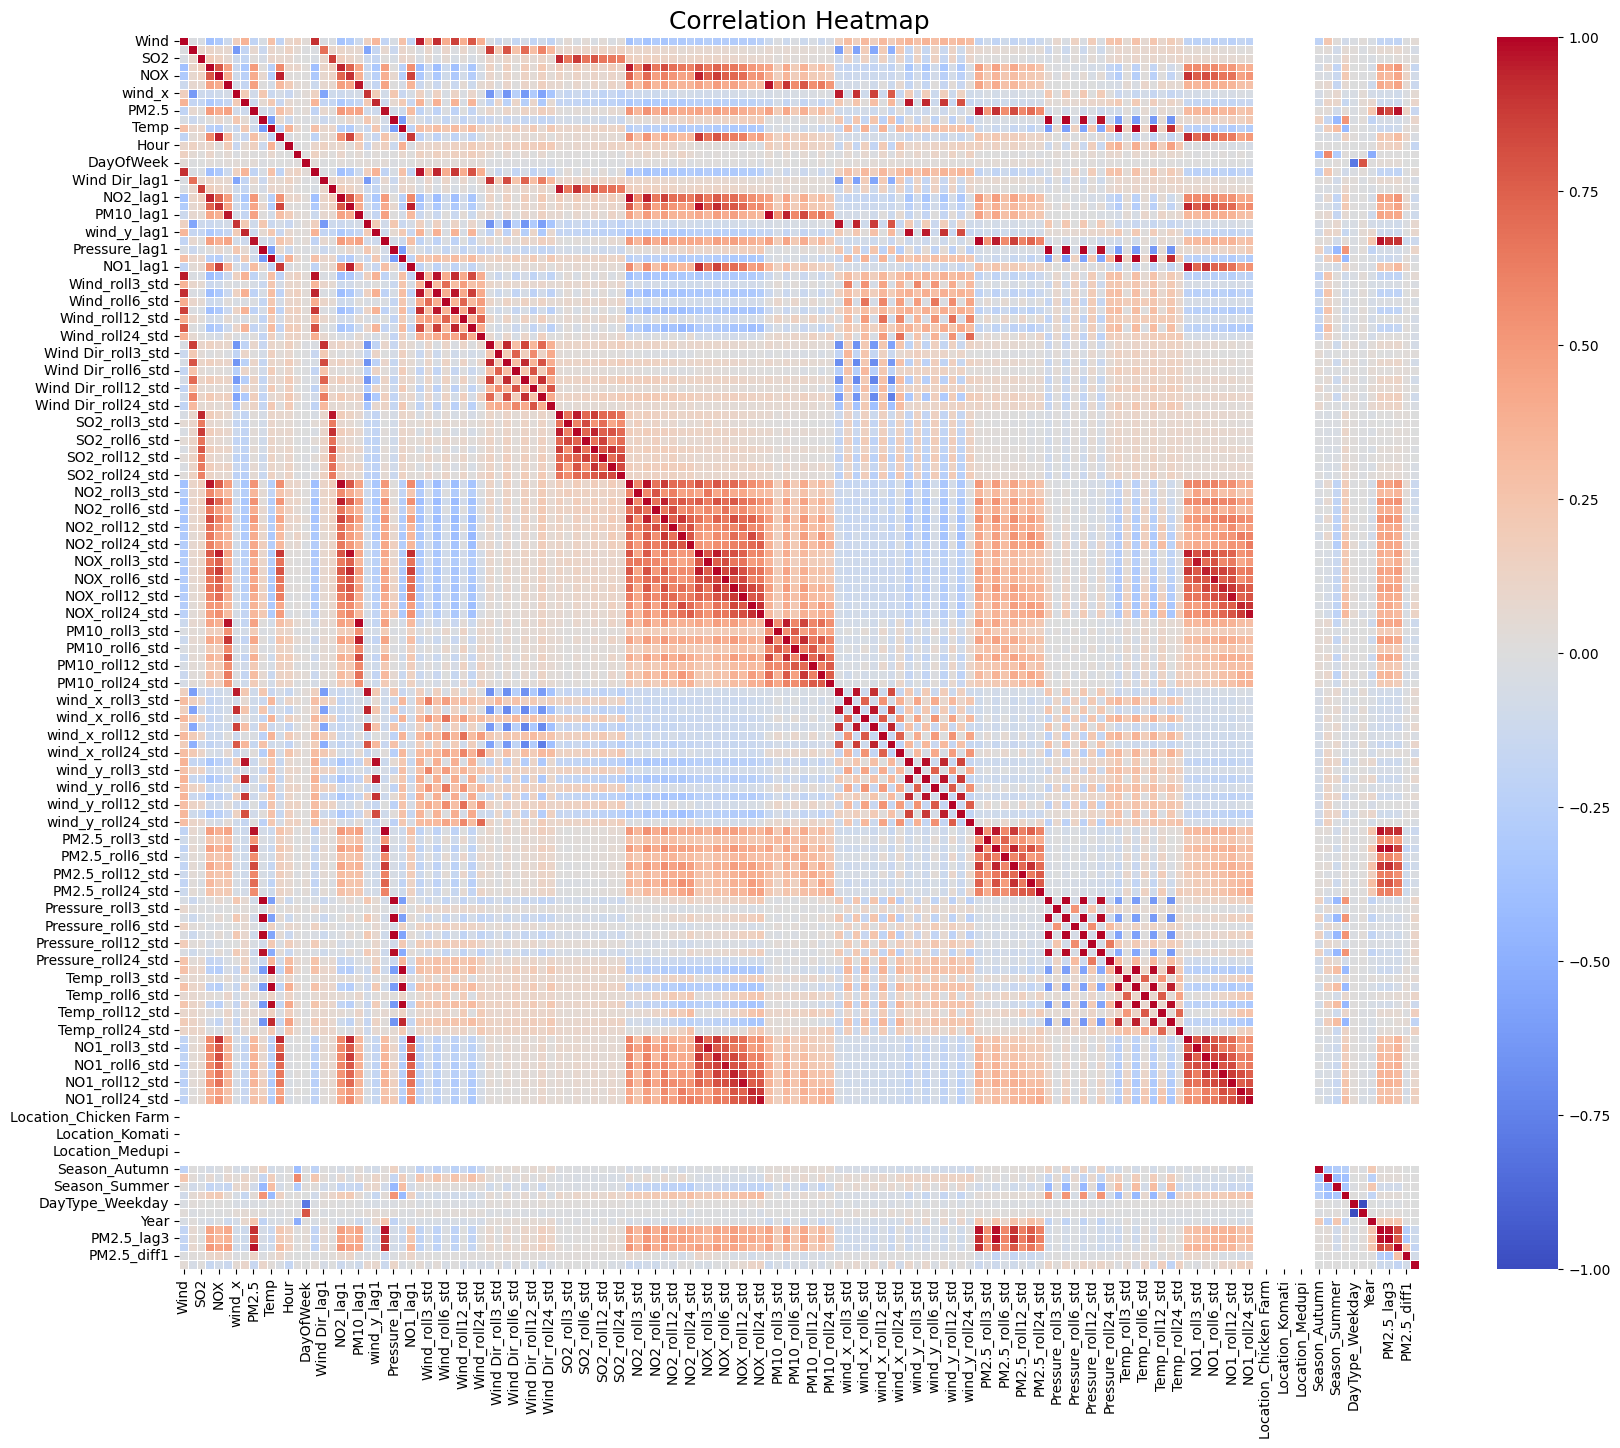

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [ ]:
# Compute correlations with the target
target = 'PM2.5_t+1'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+1:\n")
print(feature_ranking.head(20))

KeyError: 'PM2.5_t+1'

In [ ]:
feature_ranking

PM2.5                    0.827162
NO2                      0.522737
PM2.5_roll12_std         0.464254
PM2.5_roll24_std         0.460308
NOX                      0.458458
                           ...   
Wind_roll12_std          0.001091
Location_Chicken Farm         NaN
Location_Marapong             NaN
Location_Medupi               NaN
Location_Phola                NaN
Name: PM2.5_t+3, Length: 69, dtype: float64

In [11]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,2.680954,20.30426,44.313,2.617,0.555,22.74,7.777,916.0,27.65,1.077,13,7,3,2.516841,8.529169,0.000,5.321,1.458,23.62,2.834,905.0,27.37,0.502,2.637374,0.105710,2.266919,0.550574,1.497645,0.920177,1.798627,0.964621,18.719430,9.497540,40.708508,27.110201,94.994117,88.180562,77.887073,80.038890,14.771000,25.584122,10.996000,18.815210,7.880545,12.278889,6.509000,8.394480,3.969000,1.912017,6.035200,6.070248,9.903909,8.927897,7.233696,7.146458,1.006500,0.638517,8.431400,12.299268,20.084000,29.019155,12.964130,21.018689,24.196667,1.815057,20.303333,4.762666,14.824833,9.240400,13.890458,9.413803,6.554667,3.284747,8.486000,5.563704,6.895417,4.359215,9.296208,9.188592,910.500000,7.778175,910.50,7.778175,910.50,7.778175,910.500000,7.778175,26.613333,1.559370,21.240000,6.481518,16.555000,6.573053,18.632500,5.864983,0.789500,0.406586,4.375200,6.396350,12.601909,20.287885,8.135304,14.399473,False,True,False,False,False,False,True,True,False,2015,16.1460,4.943,0.28
1,3.208356,358.94160,1.033,2.163,0.839,23.24,10.480,915.0,27.48,1.860,13,7,3,2.680954,20.304260,44.313,2.617,0.555,22.74,7.777,916.0,27.65,1.077,2.802050,0.361312,2.539336,0.543388,1.697483,1.013044,1.814247,0.984928,129.258343,198.998648,87.004585,134.499380,123.996575,112.022200,91.023970,98.028647,15.115333,25.291196,10.097400,19.244165,7.546364,12.423014,6.318565,8.469817,3.367000,1.707371,3.273600,2.526524,9.487364,9.192974,7.193391,7.173452,0.950667,0.461741,2.681200,3.525696,19.523455,29.354671,12.822957,21.091808,23.200000,0.441362,21.296667,4.625541,16.344250,8.974492,14.278375,9.605374,7.030333,3.877301,8.685500,5.619182,7.170000,4.481182,9.556958,9.126924,912.000000,6.082763,912.00,6.082763,912.00,6.082763,912.000000,6.082763,27.500000,0.141067,23.853333,4.876419,17.775833,7.153194,19.045000,6.129903,1.146333,0.681650,1.698000,1.998006,12.384273,20.398928,8.073130,14.424410,False,True,False,False,False,False,True,True,False,2015,16.6060,2.703,-0.17
2,3.552827,1.62133,1.214,1.608,0.181,24.47,12.410,915.0,27.44,0.000,13,7,3,3.208356,358.941600,1.033,2.163,0.839,23.24,10.480,915.0,27.48,1.860,3.147379,0.439123,2.872985,0.414401,1.942486,1.080163,1.832926,1.014276,126.955730,201.122713,77.298838,138.880129,109.053919,115.637848,89.355048,99.238814,15.520000,24.935634,9.312000,19.574321,7.230455,12.546511,6.129609,8.535731,2

## Feature Selection

In [ ]:
features = feature_ranking.head(20).index.tolist()



In [ ]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+1'], df_test['PM2.5_t+1']])#data_for_model['PM2.5_t+3']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [14]:
y

20839    68.708
20840    37.958
20841    22.058
20842    10.908
20843     4.445
          ...  
95768     0.742
95769     0.731
95770     3.062
95771    21.130
95772    75.980
Name: PM2.5_t+3, Length: 74934, dtype: float64

## Data splitting for models

In [15]:
# Let's use 80% of the data for training, 20% for testing
split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## LSTM Model (Neural Network)

In [16]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 258.2282 - val_loss: 91.0571
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 110.1121 - val_loss: 89.4757
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 114.5444 - val_loss: 90.1353
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 113.1275 - val_loss: 90.8434
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 102.4316 - val_loss: 92.3316
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 103.5418 - val_loss: 98.4321
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - loss: 97.0867 - val_loss: 92.5980
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 96.8318 - val_loss: 89.6227
Epoch 9/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - loss: 92.9702 - val_loss: 90.1958
Epoch 10/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 104.9384 - val_loss: 89.3363
Epoch 11/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 98.7588 - val_loss: 94.4852
Epoch 12

In [17]:
#Prediction accuracy
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R²: 0.7727092479214903
RMSE: 9.357506529131483


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
#Validation data prediction
X_val = df_val[features]
y_val = df_val['PM2.5_t+3']

X_val_scaled = scaler.fit_transform(X_val)


y_pred_val = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R²: 0.6638268601924334
RMSE: 12.254978251739987


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_3hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (3 hrs ahead): {forecast_3hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Forecasted PM2.5 (3 hrs ahead): 25.47612190246582


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


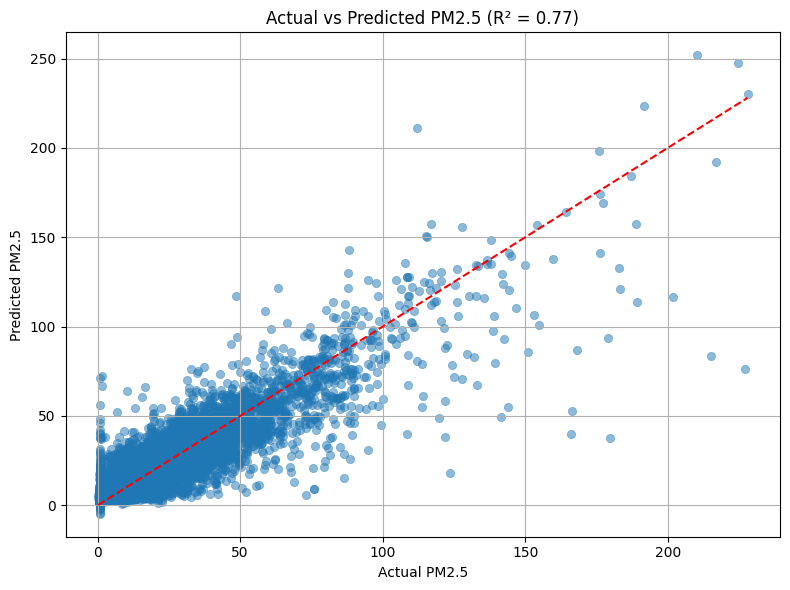

In [20]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
y_val

95773     131.30
95774     173.30
95775     189.90
95776     167.20
95777     115.30
           ...  
105712     20.23
105713     21.47
105714     25.36
105715     23.39
105716     24.91
Name: PM2.5_t+3, Length: 9944, dtype: float64

# Testing out XGBoost Regressor and Random Forrest Regressor

In [ ]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+1'], df_test['PM2.5_t+1']])#data_for_model['PM2.5_t+3']

In [22]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
#Random Forrest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [24]:
#XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


## Model Evaluation

In [25]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 5.980512639451115
RMSE: 9.995415738520872
R2 Score: 0.8192212683403257

XGBoost Performance:
MAE: 6.094548283563284
RMSE: 10.063996543823547
R2 Score: 0.816732030494601


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

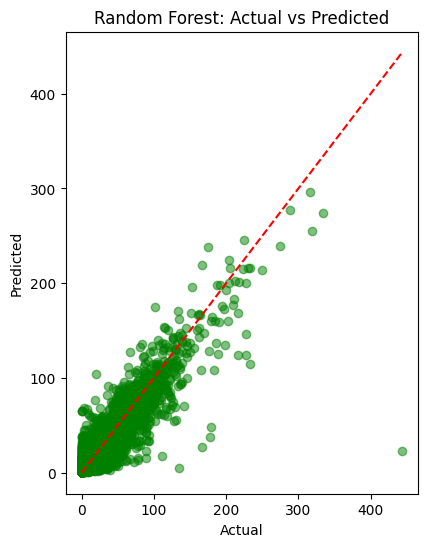

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

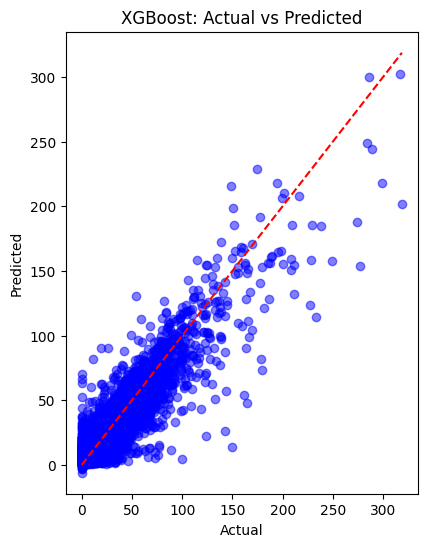

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

In [27]:
#Validation performance

rf_val = rf.predict(X_val)

xgb_val = xgb.predict(X_val)

evaluate_model("Random Forrest", y_val, rf_val)
evaluate_model("XGBoost", y_val, xgb_val )


Random Forrest Performance:
MAE: 6.670180703998389
RMSE: 11.598862602526847
R2 Score: 0.6988598041617762

XGBoost Performance:
MAE: 6.492599664403707
RMSE: 11.702875869505712
R2 Score: 0.6934346137971213


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest Validation: Actual vs Predicted')

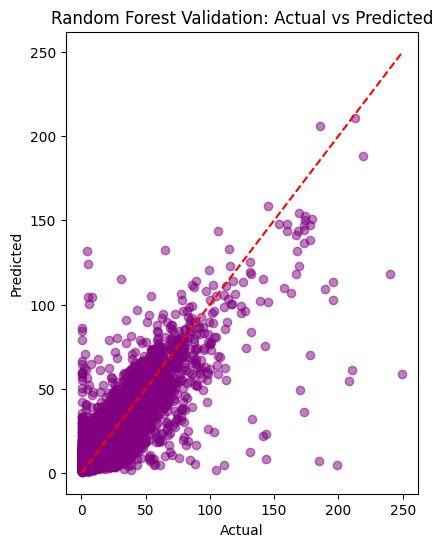

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, rf_val, alpha=0.5, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Validation: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost Validation: Actual vs Predicted')

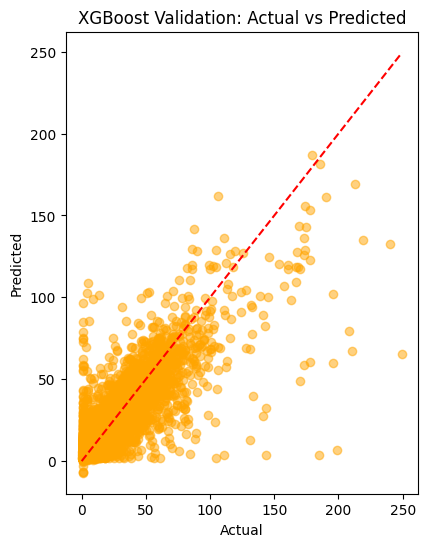

In [31]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, xgb_val, alpha=0.5, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Validation: Actual vs Predicted")

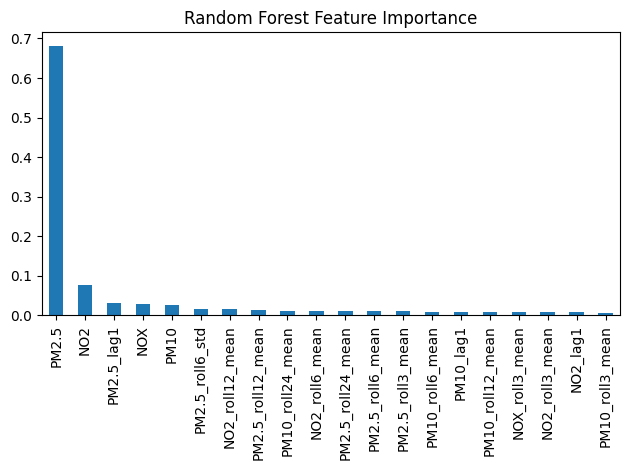

In [32]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()




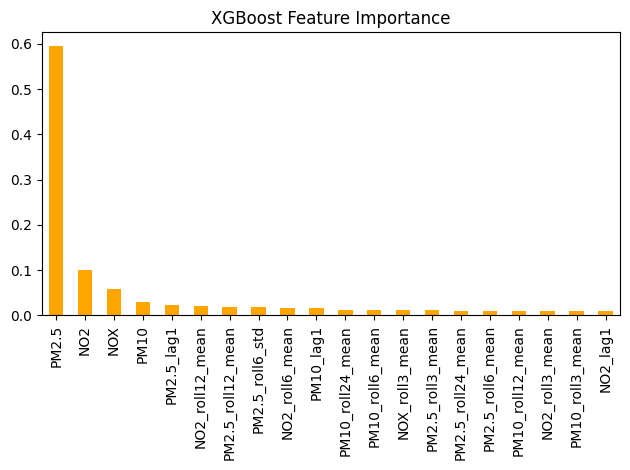

In [33]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()